In [32]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

In [3]:
USE_GPU = True
num_class = 100
dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


In [4]:
batch_size = 100
train_loader = torch.utils.data.DataLoader(
    datasets.USPS('data/USPS', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.USPS('data/USPS', train=True, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=False)

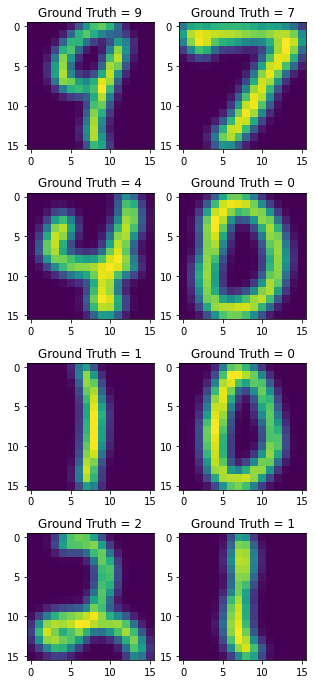

In [14]:
x, label = next(iter(train_loader))
label = label[:8].to('cpu')
x = x[:8].to('cpu')

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(5, 12))
for i in range(4):
    axes[i, 0].imshow(x[i].reshape(16,16))
    title = 'Ground Truth = ' + str(label[i])[7:-1]
    axes[i, 0].set_title(title)
    axes[i, 1].imshow(x[i+4].reshape(16,16))
    title = 'Ground Truth = ' + str(label[i+4])[7:-1]
    axes[i, 1].set_title(title)
plt.show()

In [5]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.relu1 = nn.ReLU()
        
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.relu2 = nn.ReLU()
        
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.relu4 = nn.ReLU()
        
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.relu5 = nn.ReLU()
        
        self.fc6 = nn.Linear(h_dim1, x_dim)
        self.relu6 = nn.ReLU()
        
    def encoder(self, x):
        h = self.fc1(x)
        h = self.relu1(h)
        
        h = self.fc2(h)
        h = self.relu2(h)
        
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = self.fc4(z)
        h = self.relu4(h)
        
        h = self.fc5(h)
        h = self.relu5(h)
        
        return torch.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 256))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var
    
vae_usps = VAE(x_dim=256, h_dim1= 128, h_dim2=64, z_dim=2)
if torch.cuda.is_available():
    vae_usps.cuda()

In [43]:
optimizer_usps = optim.Adam(vae_usps.parameters())

# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x.cuda(), x.view(-1, 256).cuda(), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [6]:
def train(epoch):
    vae_usps.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        #data = data.cuda()
        optimizer_usps.zero_grad()
        
        recon_batch, mu, log_var = vae_usps(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer_usps.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [7]:
def test():
    vae_usps.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            #data = data.cuda()
            recon, mu, log_var = vae_usps(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [10]:
# Just run this cell ONCE
# build model
#vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2, dataset_len = 784)
if torch.cuda.is_available():
    vae_usps.cuda()
    
for epoch in range(1, 11):
    train(epoch)
    test()

torch.save(vae_usps.state_dict(), 'model_weights_USPS.pth')

Train Epoch: 1 [0/7291 (0%)]	Loss: 115.109971
====> Epoch: 1 Average loss: 107.3016
====> Test set loss: 106.4348
Train Epoch: 2 [0/7291 (0%)]	Loss: 105.522822
====> Epoch: 2 Average loss: 106.0720
====> Test set loss: 105.6742
Train Epoch: 3 [0/7291 (0%)]	Loss: 110.097344
====> Epoch: 3 Average loss: 105.4492
====> Test set loss: 105.1520
Train Epoch: 4 [0/7291 (0%)]	Loss: 105.865889
====> Epoch: 4 Average loss: 105.0644
====> Test set loss: 104.8658
Train Epoch: 5 [0/7291 (0%)]	Loss: 105.328350
====> Epoch: 5 Average loss: 104.6327
====> Test set loss: 104.4177
Train Epoch: 6 [0/7291 (0%)]	Loss: 106.877627
====> Epoch: 6 Average loss: 104.3222
====> Test set loss: 104.2117
Train Epoch: 7 [0/7291 (0%)]	Loss: 101.553584
====> Epoch: 7 Average loss: 104.0603
====> Test set loss: 103.9001
Train Epoch: 8 [0/7291 (0%)]	Loss: 101.723809
====> Epoch: 8 Average loss: 103.8442
====> Test set loss: 103.7853
Train Epoch: 9 [0/7291 (0%)]	Loss: 101.055518
====> Epoch: 9 Average loss: 103.7150
====

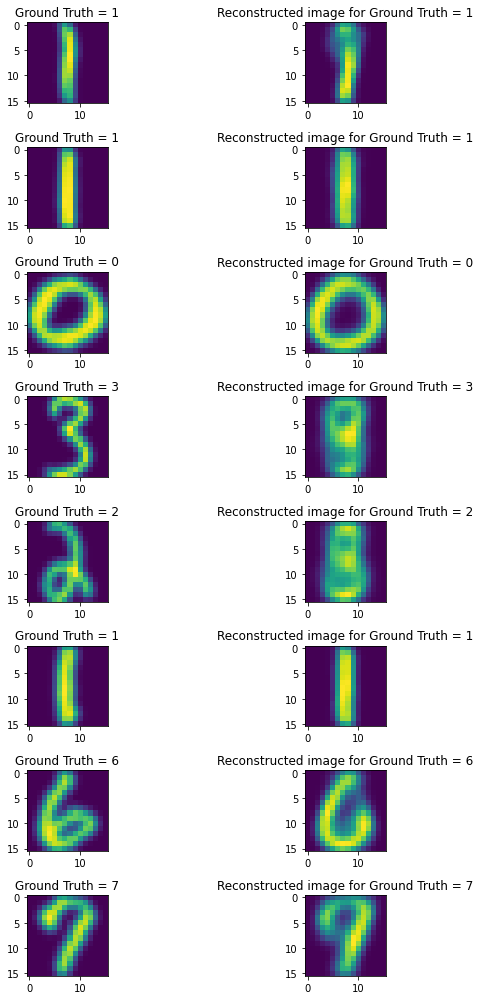

In [16]:
x, label = next(iter(train_loader))
label = label[:8].to('cpu')
x = x[:8].to('cpu')

# Generate the reconstructed images
x_recon, _, _ = model(x)
x_recon = x_recon.cpu().detach()

x = np.transpose(x.detach().cpu().numpy(), (0, 2, 3, 1))

x_recon = np.transpose(x_recon.detach().cpu().numpy(), (0, 1))
x_recon = x_recon.reshape(8,16,16,1)

fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(10, 14))
for i in range(8):
    axes[i, 0].imshow(x[i])
    title = 'Ground Truth = ' + str(label[i])[7:-1]
    axes[i, 0].set_title(title)
    axes[i, 1].imshow(x_recon[i])
    title = 'Reconstructed image for Ground Truth = ' + str(label[i])[7:-1]
    axes[i, 1].set_title(title)
plt.tight_layout()
plt.show()

In [12]:
def train(epoch):
    vae_usps.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        #data = data.cuda()
        optimizer_usps.zero_grad()
        
        recon_batch, mu, log_var = vae_usps(data.cuda())
        loss = loss_function(recon_batch, data.cuda(), mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer_usps.step()
        
        #if batch_idx % 100 == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, batch_idx * len(data), len(train_loader.dataset),
                #100. * batch_idx / len(train_loader), loss.item() / len(data)))
    #print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))


test_losses = []
def test():
    vae_usps.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            #data = data.cuda()
            recon, mu, log_var = vae_usps(data.cuda())
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

batch_sizes = [50, 100, 150, 200, 250]
for bs in batch_sizes:
    train_loader = torch.utils.data.DataLoader(
    datasets.USPS('data/USPS', train=True, download=True, transform=transforms.ToTensor()), batch_size=bs, shuffle=True)

    test_loader = torch.utils.data.DataLoader(
    datasets.USPS('data/USPS', train=True, transform=transforms.ToTensor()), batch_size=bs, shuffle=False)
    
    for epoch in range(1, 11):
        train(epoch)
        test()

Text(0, 0.5, 'Test Loss')

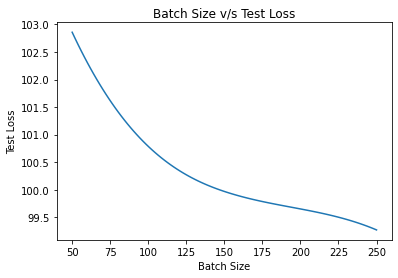

In [40]:
epcs = range(1,11)
test_losses_final = [test_losses[9],test_losses[19],test_losses[29],test_losses[39],test_losses[49]]
plt.figure()

X_Y_Spline = make_interp_spline(batch_sizes, test_losses_final)
 
# Returns evenly spaced numbers
# over a specified interval.
X_ = np.linspace(np.array(batch_sizes).min(), np.array(batch_sizes).max(), 100)
Y_ = X_Y_Spline(X_)
 
# Plotting the Graph
plt.plot(X_, Y_)
#plt.plot(batch_sizes, test_losses_final)
plt.title('Batch Size v/s Test Loss')
plt.xlabel('Batch Size')
plt.ylabel('Test Loss')

In [44]:
def train(epoch):
    vae_usps.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        #data = data.cuda()
        optimizer_usps.zero_grad()
        
        recon_batch, mu, log_var = vae_usps(data.cuda())
        loss = loss_function(recon_batch, data.cuda(), mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer_usps.step()
        
        #if batch_idx % 100 == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, batch_idx * len(data), len(train_loader.dataset),
                #100. * batch_idx / len(train_loader), loss.item() / len(data)))
    #print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))


test_losses2 = []
def test():
    vae_usps.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            #data = data.cuda()
            recon, mu, log_var = vae_usps(data.cuda())
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    test_losses2.append(test_loss)

lrs = [0.0001, 0.001, 0.005, 0.01]
for lr in lrs:
    train_loader = torch.utils.data.DataLoader(
    datasets.USPS('data/USPS', train=True, download=True, transform=transforms.ToTensor()), batch_size=bs, shuffle=True)

    test_loader = torch.utils.data.DataLoader(
    datasets.USPS('data/USPS', train=True, transform=transforms.ToTensor()), batch_size=bs, shuffle=False)
    
    optimizer_usps = optim.Adam(vae_usps.parameters(), lr)
    for epoch in range(1, 11):
        train(epoch)
        test()

Text(0, 0.5, 'Test Loss')

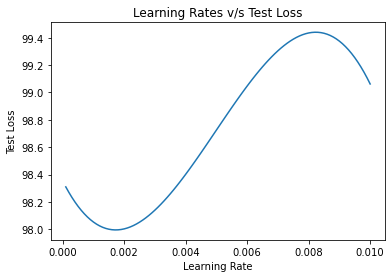

In [45]:
test_losses_final = [test_losses2[9],test_losses2[19],test_losses2[29],test_losses2[39]]
plt.figure()
X_Y_Spline = make_interp_spline(lrs, test_losses_final)
 
# Returns evenly spaced numbers
# over a specified interval.
X_ = np.linspace(np.array(lrs).min(), np.array(lrs).max(), 100)
Y_ = X_Y_Spline(X_)
 
# Plotting the Graph
plt.plot(X_, Y_)
#plt.plot(lrs, test_losses_final)
plt.title('Learning Rates v/s Test Loss')
plt.xlabel('Learning Rate')
plt.ylabel('Test Loss')

In [16]:
# Rather than training the model again and again, use saved weights 

model = VAE(x_dim=256, h_dim1= 128, h_dim2=64, z_dim=2)
model.load_state_dict(torch.load('model_weights_USPS.pth'))

<All keys matched successfully>

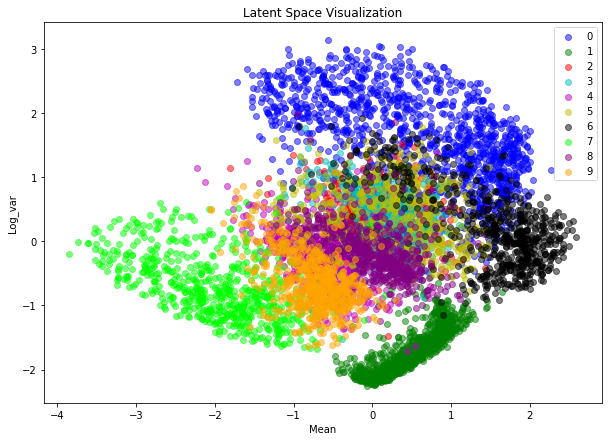

In [17]:
latent_space = {i: [] for i in range(10)}

# extract latent space for each data point
model.eval()
with torch.no_grad():
    for data, label in test_loader:
#         if torch.cuda.is_available():
#             data = data.cuda()
        recon_batch, mu, log_var = model(data)
        z = model.sampling(mu, log_var)
        for i in range(len(label)):
            latent_space[label[i].item()].append(mu[i].cpu().numpy())

# plot mu and log_var for each class with different colors
fig = plt.figure(figsize=(10, 7))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'lime', 'purple', 'orange']
for i in range(10):
    mu_list = [latent_space[i][j][0] for j in range(len(latent_space[i]))]
    log_var_list = [latent_space[i][j][1] for j in range(len(latent_space[i]))]
    plt.scatter(mu_list, log_var_list, color=colors[i], label=str(i), alpha=0.5)
plt.xlabel('Mean')
plt.ylabel('Log_var')
plt.title('Latent Space Visualization')
plt.legend()
plt.show()

In [18]:
# CVAE

In [19]:
latent_size = 20
epochs = 10

In [20]:
# One hot encoding (For Conditional Part)
def one_hot(labels, class_size):
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return targets.to(device)

In [23]:
class CVAE(nn.Module):
    def __init__(self, feature_size, latent_size, class_size):
        super(CVAE, self).__init__()
        self.feature_size = feature_size
        self.class_size = class_size

        # encode
        self.fc1  = nn.Linear(feature_size + class_size, 400)
        self.fc21 = nn.Linear(400, latent_size)
        self.fc22 = nn.Linear(400, latent_size)

        # decode
        self.fc3 = nn.Linear(latent_size + class_size, 400)
        self.fc4 = nn.Linear(400, feature_size)

        self.elu = nn.ELU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x, c): # Q(z|x, c)
        '''
        x: (bs, feature_size)
        c: (bs, class_size)
        '''
        inputs = torch.cat([x, c], 1) # (bs, feature_size+class_size)
        h1 = self.elu(self.fc1(inputs))
        z_mu = self.fc21(h1)
        z_var = self.fc22(h1)
        return z_mu, z_var

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z, c): # P(x|z, c)
        '''
        z: (bs, latent_size)
        c: (bs, class_size)
        '''
        inputs = torch.cat([z, c], 1) # (bs, latent_size+class_size)
        h3 = self.elu(self.fc3(inputs))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x, c):
        mu, logvar = self.encode(x.view(-1, 16*16), c)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, c), mu, logvar

In [24]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 256), reduction='sum')
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [25]:
# create a CVAE model
model_cvae = CVAE(16*16, latent_size, 10).to(device)

optimizer = optim.Adam(model_cvae.parameters(), lr=1e-3)

In [26]:
def train(epoch):
    model_cvae.train()
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        labels = one_hot(labels, 10)
        recon_batch, mu, logvar = model_cvae(data, labels)
        optimizer.zero_grad()
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.detach().cpu().numpy()
        optimizer.step()
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

def test(epoch):
    model_cvae.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, labels) in enumerate(test_loader):
            data, labels = data.to(device), labels.to(device)
            labels = one_hot(labels, 10)
            recon_batch, mu, logvar = model_cvae(data, labels)
            test_loss += loss_function(recon_batch, data, mu, logvar).detach().cpu().numpy()
            if i == 0:
                n = min(data.size(0), 5)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(-1, 1, 16, 16)[:n]])
                save_image(comparison.cpu(),
                         'samples_MNIST/reconstruction_usps_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [27]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    with torch.no_grad():
        c = torch.eye(10, 10).cuda()
        sample = torch.randn(10, 20).to(device)
        sample = model_cvae.decode(sample, c).cpu()
        save_image(sample.view(10, 1, 16, 16),
                   'samples_MNIST/sample_usps_' + str(epoch) + '.png')

Train Epoch: 1 [0/7291 (0%)]	Loss: 179.529969
Train Epoch: 1 [5000/7291 (67%)]	Loss: 126.510281
====> Epoch: 1 Average loss: 140.8503
====> Test set loss: 118.4369
Train Epoch: 2 [0/7291 (0%)]	Loss: 118.946109
Train Epoch: 2 [5000/7291 (67%)]	Loss: 112.099727
====> Epoch: 2 Average loss: 113.6608
====> Test set loss: 109.9138
Train Epoch: 3 [0/7291 (0%)]	Loss: 111.424867
Train Epoch: 3 [5000/7291 (67%)]	Loss: 107.354945
====> Epoch: 3 Average loss: 107.6863
====> Test set loss: 105.6581
Train Epoch: 4 [0/7291 (0%)]	Loss: 104.544047
Train Epoch: 4 [5000/7291 (67%)]	Loss: 104.234164
====> Epoch: 4 Average loss: 104.3363
====> Test set loss: 103.2477
Train Epoch: 5 [0/7291 (0%)]	Loss: 101.259727
Train Epoch: 5 [5000/7291 (67%)]	Loss: 104.387805
====> Epoch: 5 Average loss: 102.0468
====> Test set loss: 101.1193
Train Epoch: 6 [0/7291 (0%)]	Loss: 102.086195
Train Epoch: 6 [5000/7291 (67%)]	Loss: 99.647984
====> Epoch: 6 Average loss: 100.2363
====> Test set loss: 99.4838
Train Epoch: 7 [0/

In [28]:
torch.save(model_cvae.state_dict(), 'model_cvae_weights_USPS.pth')

In [29]:
model = CVAE(16*16, latent_size, 10)
model.load_state_dict(torch.load('model_cvae_weights_USPS.pth'))

<All keys matched successfully>

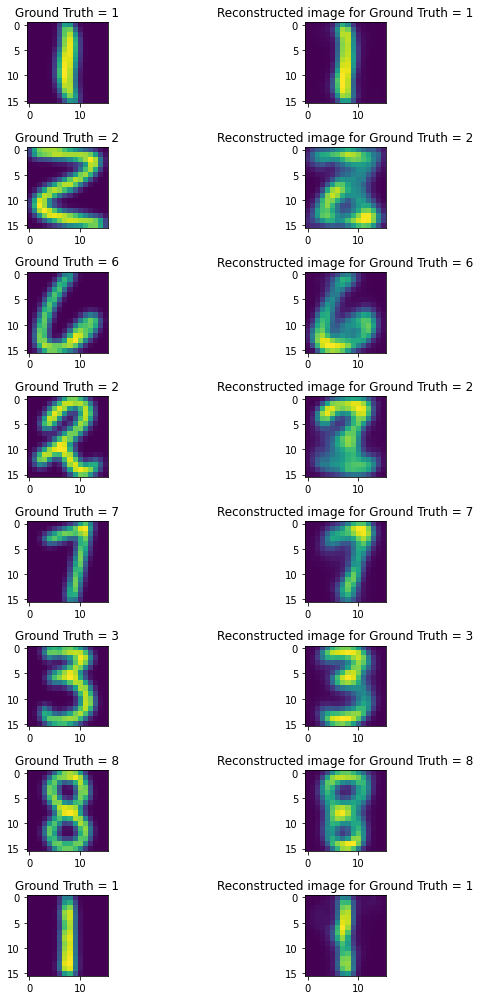

In [30]:
x, label = next(iter(train_loader))
label = label[:8].to('cpu')
x = x[:8].to('cpu')

labels = one_hot(label, 10).to('cpu')
# Generate the reconstructed images
x_recon, _, _ = model(x,labels)
x_recon = x_recon.cpu().detach()


x_recon = x_recon.reshape(8,16,16,1)

fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(10, 14))
for i in range(8):
    axes[i, 0].imshow(x[i].reshape(16,16))
    title = 'Ground Truth = ' + str(label[i])[7:-1]
    axes[i, 0].set_title(title)
    axes[i, 1].imshow(x_recon[i])
    title = 'Reconstructed image for Ground Truth = ' + str(label[i])[7:-1]
    axes[i, 1].set_title(title)
plt.tight_layout()
plt.show()

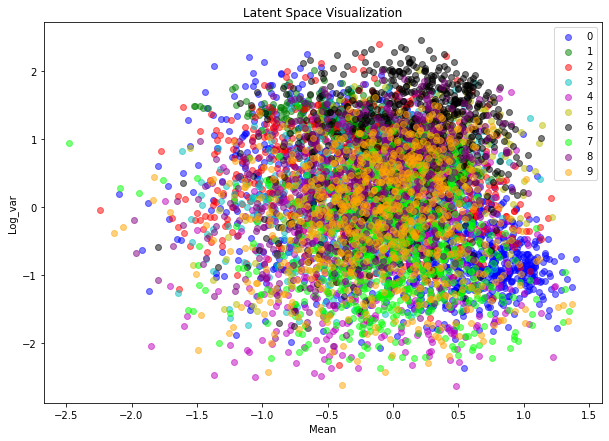

In [31]:
latent_space = {i: [] for i in range(10)}

# extract latent space for each data point
model.eval()
with torch.no_grad():
    for data, label in test_loader:
#         if torch.cuda.is_available():
#             data = data.cuda()
        recon_batch, mu, log_var = model(data, one_hot(label,10).cpu())
#         std = torch.exp(0.5*log_var)
#         eps = torch.randn_like(std)
#         z = eps.mul(std).add_(mu)
        z = model.reparameterize(mu, log_var)
        for i in range(len(label)):
            latent_space[label[i].item()].append(mu[i].cpu().numpy())

# plot mu and log_var for each class with different colors
fig = plt.figure(figsize=(10, 7))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'lime', 'purple', 'orange']
for i in range(10):
    mu_list = [latent_space[i][j][0] for j in range(len(latent_space[i]))]
    log_var_list = [latent_space[i][j][1] for j in range(len(latent_space[i]))]
    plt.scatter(mu_list, log_var_list, color=colors[i], label=str(i), alpha=0.5)
plt.xlabel('Mean')
plt.ylabel('Log_var')
plt.title('Latent Space Visualization')
plt.legend()
plt.show()